<a href="https://colab.research.google.com/github/recognita/EIM-for-Muscle-Construction-Detection/blob/main/challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [4]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/AN2DL/challenge1"
%cd $current_dir

Mounted at /gdrive
/gdrive/My Drive/AN2DL/challenge1


## ⚙️ **Libraries** **Import**

In [5]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from scipy.stats import norm, ttest_ind
from scipy.signal import welch


from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cpu


## ⏳ **Data Loading**

In [6]:

# Set environment variables for dataset paths
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["TRAIN_URL"] = "1yRqrSB1JQwH09p1fXpO7lNfQZBl0PSBs"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["LABEL_URL"] = "1BhWWiWQeBt9R4BcenRjzuuO0-VKQV8oJ"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"
os.environ["TEST_URL"] = "1fXPfRottySriJF2uyRzpUgOI5affanMa"

# Check if Activity Recognition dataset exists and download if not
if not os.path.exists(os.environ["TRAIN_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TRAIN_URL} -O ${TRAIN_FILE}
    print("Activity Recognition dataset1 downloaded!")
else:
    print("Activity Recognition dataset1 already downloaded. Using cached data.")

if not os.path.exists(os.environ["LABEL_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${LABEL_URL} -O ${LABEL_FILE}
    print("Activity Recognition dataset2 downloaded!")
else:
    print("Activity Recognition dataset2 already downloaded. Using cached data.")

if not os.path.exists(os.environ["TEST_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TEST_URL} -O ${TEST_FILE}
    print("Activity Recognition dataset3 downloaded!")
else:
    print("Activity Recognition dataset3 already downloaded. Using cached data.")



Activity Recognition dataset1 already downloaded. Using cached data.
Activity Recognition dataset2 already downloaded. Using cached data.
Activity Recognition dataset3 already downloaded. Using cached data.


## 🔎 **Exploration and Data Analysis**


In [7]:
# Load the dataset from a CSV file
dataset_train = pd.read_csv('pirate_pain_train.csv')
dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
dataset_test = pd.read_csv('pirate_pain_test.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset_train.shape}")
print(f"Dataset shape: {dataset_labels.shape}")

# Display the first few rows of the dataset
dataset_train.head()
#661 is the number of people

Dataset shape: (105760, 40)
Dataset shape: (661, 2)


sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4 n_legs n_hands n_eyes  joint_00  ...      joint_21  \
0              1    two     two    two  1.094705  ...  3.499558e-06   
1              2    two     two    two  1.135183  ...  3.976952e-07   
2              2    two     two    two  1.080745  ...  1.533820e-07   
3              2    two     two    two  0.938017  ...  1.006865e-05   
4              2    two     two    two  1.090185  ...  4.437266e-06   

       joint_22  joint_23      joint_24  joint_25  joint_26  joint_27  \
0  1.945042e-06  0.000004  1.153299e-05  0.000004  0.017592  0.013508   
1  6.765107e-07  0.000006  4.643774e-08  0.000000  0.013352  0.000000   
2  1.698525e-07  0.000001  2.424536e-06  0.000003  0.016225  0.008110   
3  5.511079e-07  0.000002  5.432416e-08  0.000000  0.011832  0.007450   
4  1.735459e-07  0.000002  5.825366e-08  0.000007  0.005360  0.002532   

   joint_28  joint_29  joint_30  
0  0.026798  0.027815       0.5  
1  0.013377  0.013716       0.5  
2  0.024097  0.023105       0.5  
3  0.028613  0.024648       0.5  
4  0.033026  0.025328       0.5  

[5 rows x 40 columns]

In [8]:

#Everyone did 160 seconds or 2 min
counts_per_sample = dataset_train.groupby('sample_index')['time'].count()
all_160_timesteps = (counts_per_sample == 160).all()
print(f"All subjects have 160 time steps: {all_160_timesteps}")

All subjects have 160 time steps: True


In [11]:
print(dataset_train.isna().mean().sort_values(ascending=False).head(10))
print(dataset_train['sample_index'].nunique(), dataset_labels['sample_index'].nunique())

sample_index     0.0
time             0.0
pain_survey_1    0.0
pain_survey_2    0.0
pain_survey_3    0.0
pain_survey_4    0.0
n_legs           0.0
n_hands          0.0
n_eyes           0.0
joint_00         0.0
dtype: float64
661 661


- No missing values: All columns show a mean of 0.0 for null values, meaning the dataset is clean and doesn't require imputation or removal of NaNs.

- Subject count consistency: Both dataset_train and dataset_labels contain 661 unique sample_index entries, confirming alignment between features and labels.

dataset_train['sample_index'].nunique() = 661

dataset_labels['sample_index'].nunique() = 661

# Is it balance or imbalance?

In [12]:
dataset_labels['label'].value_counts()

label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

In [13]:
dataset_labels['label'].value_counts(normalize=True)

label
no_pain      0.773071
low_pain     0.142209
high_pain    0.084720
Name: proportion, dtype: float64

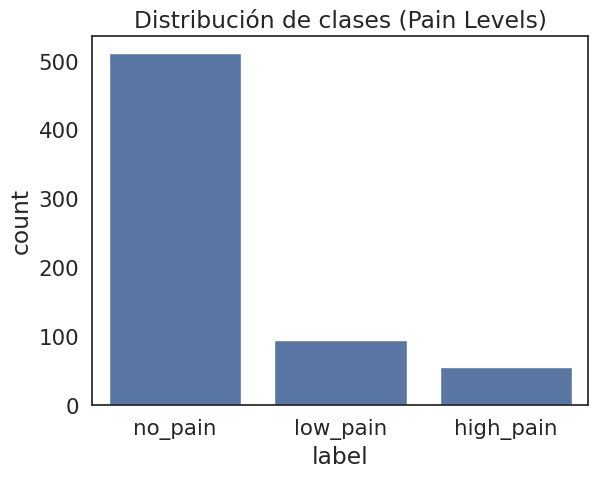

In [14]:
sns.countplot(data=dataset_labels, x='label')
plt.title('Distribución de clases (Pain Levels)')
plt.show()


Result: class imbalance, tend to no_pain

# NOISE


# Step 1: Visual inspection (plots)

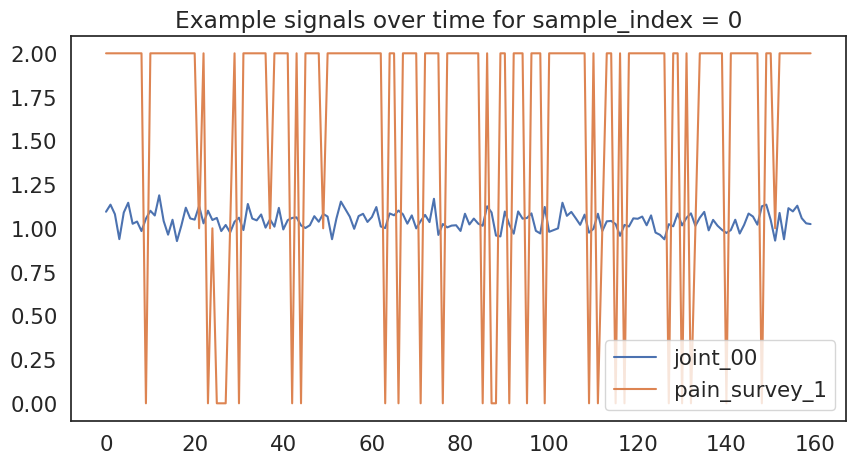

In [15]:
subject = dataset_train[dataset_train['sample_index'] == 0]

plt.figure(figsize=(10,5))
plt.plot(subject['time'], subject['joint_00'], label='joint_00')
plt.plot(subject['time'], subject['pain_survey_1'], label='pain_survey_1')
plt.legend()
plt.title('Example signals over time for sample_index = 0')
plt.show()

Find the kept-up average line,

In [16]:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(dataset_train.select_dtypes(float))

low_var_cols = dataset_train.select_dtypes(float).columns[~selector.get_support()]
print("Low variance features:", low_var_cols.tolist())


Low variance features: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_23', 'joint_24', 'joint_30']


This lines are to find sensors with unusually large or unstable values.

In [17]:
stats = dataset_train.describe().T
stats['range'] = stats['max'] - stats['min']
stats['std_over_mean'] = stats['std'] / stats['mean'].abs()

stats[['range', 'std_over_mean']].sort_values('std_over_mean', ascending=False).head(10)

range  std_over_mean
joint_22  1.305001     131.015423
joint_21  1.442198     125.235102
joint_23  0.274241      34.686300
joint_25  0.947354      31.291376
joint_19  0.616061      20.430056
joint_20  1.096014      20.275951
joint_14  0.264232      18.363109
joint_18  0.728382      17.025618
joint_16  0.188807      15.010470
joint_13  0.073852      13.007174

The ones that we need to remove are:

['joint_13','joint_14', 'joint_15','joint_16','joint_18','joint_19','joint_20',
  'joint_21','joint_22','joint_23','joint_24','joint_25','joint_30']

# Class imbalance Solution

In [18]:
classes = np.unique(dataset_labels['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=dataset_labels['label']
)
class_weights = dict(zip(classes, class_weights))
print(class_weights)


{'high_pain': np.float64(3.9345238095238093), 'low_pain': np.float64(2.3439716312056738), 'no_pain': np.float64(0.43118069145466403)}


So then in the model training you use this:

class_weights_tensor = torch.tensor([class_weights[c] for c in classes], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



# Remove unnecessary or noisy features


In [19]:
# List of noisy / unnecessary features
noisy_features = [
    'joint_13', 'joint_14', 'joint_15', 'joint_16',
    'joint_18', 'joint_19', 'joint_20', 'joint_21',
    'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'
]

# Remove them off the dataset
dataset_train_clean = dataset_train.drop(columns=[c for c in noisy_features if c in dataset_train.columns], errors='ignore')
dataset_test_clean  = dataset_test.drop(columns=[c for c in noisy_features if c in dataset_test.columns], errors='ignore')

print("✅ Removed noisy features.")
print(f"Original dataset_train shape: {dataset_train.shape}")
print(f"Cleaned  dataset_train shape: {dataset_train_clean.shape}")
print(f"Original dataset_test shape:  {dataset_test.shape}")
print(f"Cleaned  dataset_test shape:  {dataset_test_clean.shape}")


✅ Removed noisy features.
Original dataset_train shape: (105760, 40)
Cleaned  dataset_train shape: (105760, 27)
Original dataset_test shape:  (211840, 40)
Cleaned  dataset_test shape:  (211840, 27)


Create NEW datasets with "disability" column and also drop the previous (3) separate ones.

In [20]:
# NEW copies of train and test sets with disability column
dataset_train_with_disability = dataset_train_clean.copy()
dataset_test_with_disability = dataset_test_clean.copy()

# Anything non-two (eyes, hands, legs)
def is_disabled(value): return value != 'two'

# Every row checks across n_legs, n_hands, n_eyes
dataset_train_with_disability['disability'] = dataset_train_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

dataset_test_with_disability['disability'] = dataset_test_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

    # Convert it to float before training?

# Drop the old columns
dataset_train_with_disability = dataset_train_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])
dataset_test_with_disability = dataset_test_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

Display new disability set changes:

In [21]:
print("Original columns:", dataset_train_clean.columns[:10])
print("New columns:", dataset_train_with_disability.columns[:10])
print("Number of disabled subjects entries:", dataset_train_with_disability['disability'].sum())
disabled_subjects = dataset_train_with_disability.groupby('sample_index')['disability'].max().sum()
print("Number of unique disabled subjects:", disabled_subjects)
print("Disabled subjects are this percentage (%) of the total subjects:", disabled_subjects/dataset_train['sample_index'].nunique()*100)
dataset_train_with_disability.head() # Disability column at the end

Original columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes',
       'joint_00'],
      dtype='object')
New columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02',
       'joint_03'],
      dtype='object')
Number of disabled subjects entries: 960
Number of unique disabled subjects: 6
Disabled subjects are this percentage (%) of the total subjects: 0.9077155824508321


sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4  joint_00  joint_01  joint_02  joint_03  ...  joint_09  \
0              1  1.094705  0.985281  1.018302  1.010385  ...  1.050142   
1              2  1.135183  1.021175  0.994343  1.052364  ...  1.060313   
2              2  1.080745  0.962842  1.009588  0.977169  ...  1.011410   
3              2  0.938017  1.081592  0.998021  0.987283  ...  1.047223   
4              2  1.090185  1.032145  1.008710  0.963658  ...  1.044731   

   joint_10  joint_11  joint_12  joint_17  joint_26  joint_27  joint_28  \
0  0.529555  0.447370  1.091046  0.000000  0.017592  0.013508  0.026798   
1  0.446810  0.414432  1.045862  0.000009  0.013352  0.000000  0.013377   
2  0.432499  0.431535  1.088221  0.000000  0.016225  0.008110  0.024097   
3  0.478806  0.420665  1.096832  0.000035  0.011832  0.007450  0.028613   
4  0.452906  0.476537  1.103968  0.000000  0.005360  0.002532  0.033026   

   joint_29  disability  
0  0.027815           0  
1  0.013716           0  
2  0.023105           0  
3  0.024648           0  
4  0.025328           0  

[5 rows x 25 columns]

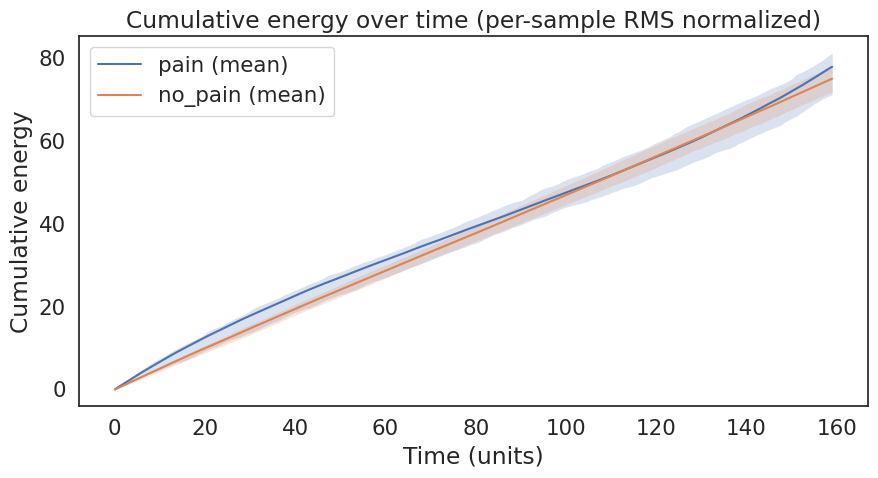

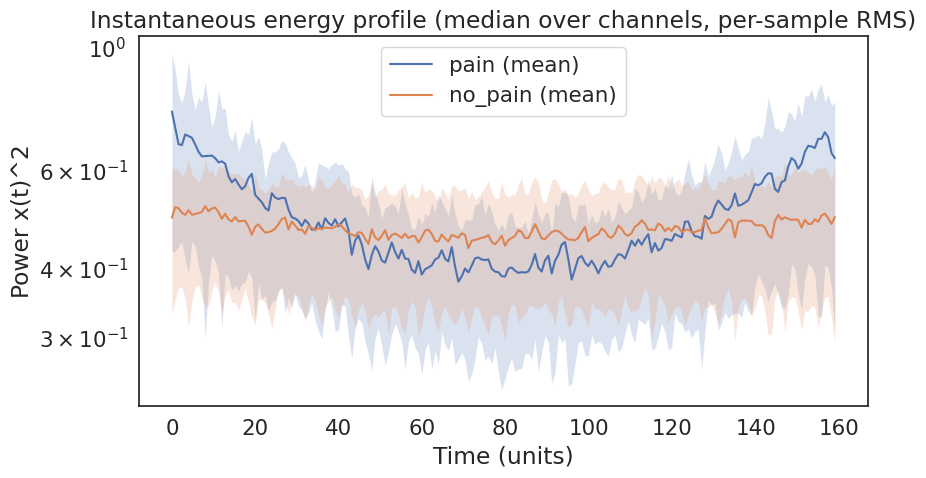

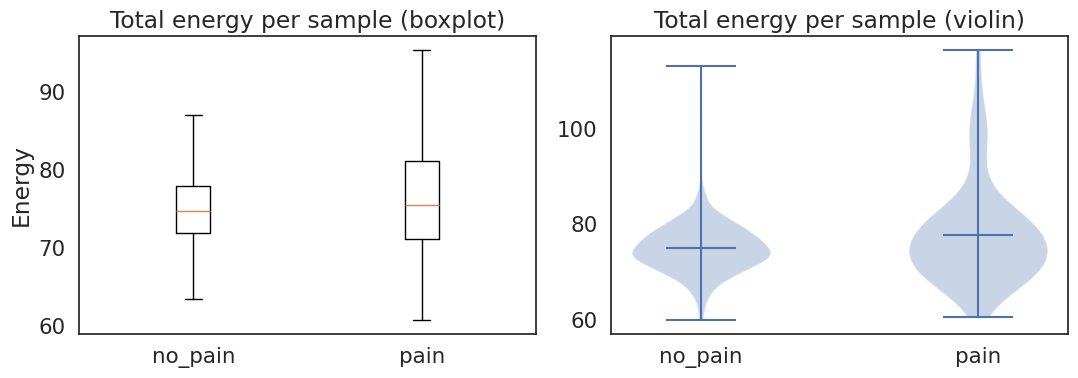

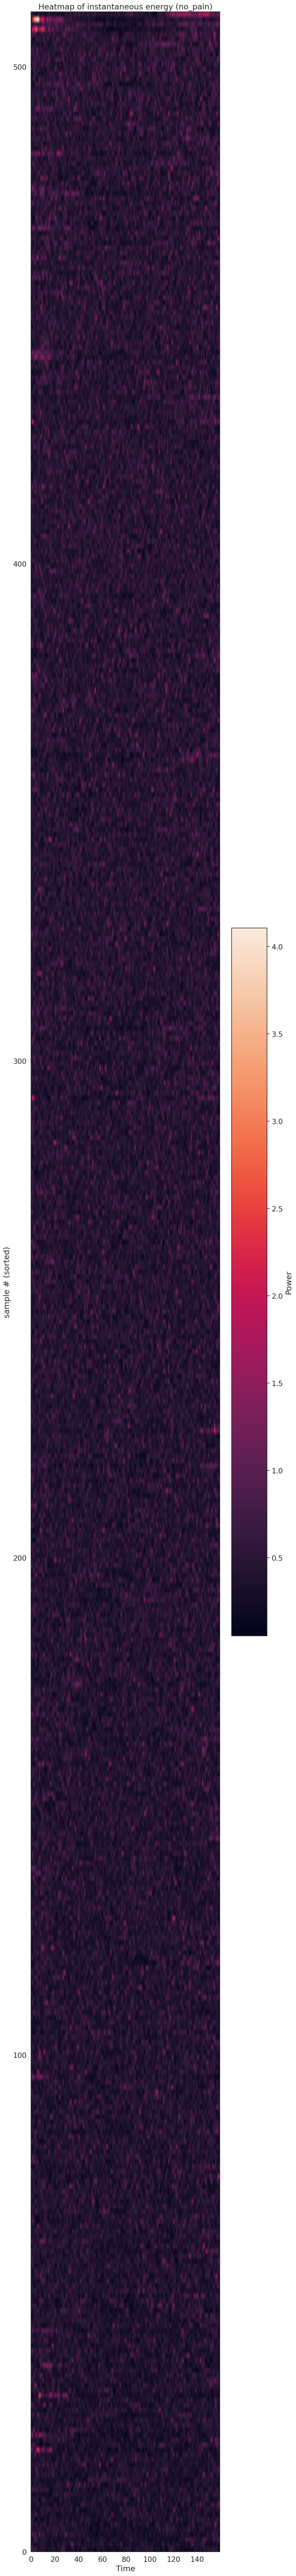

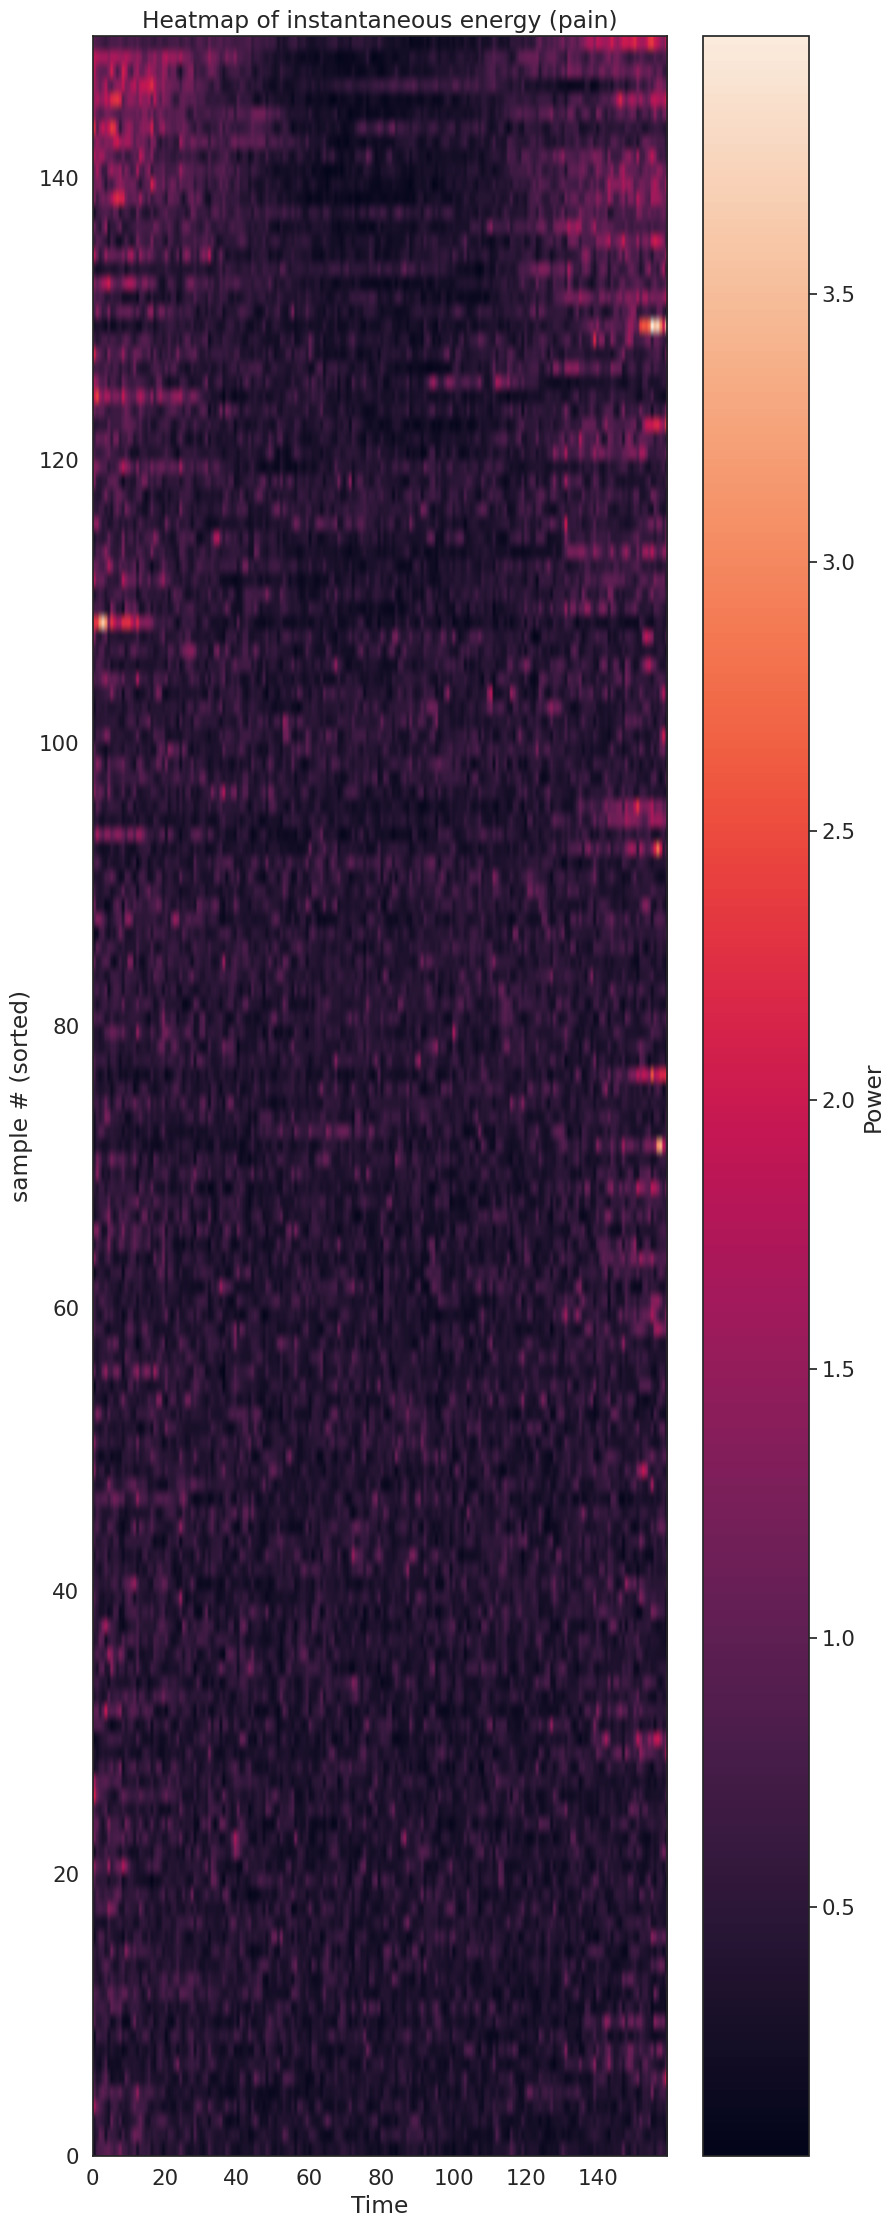

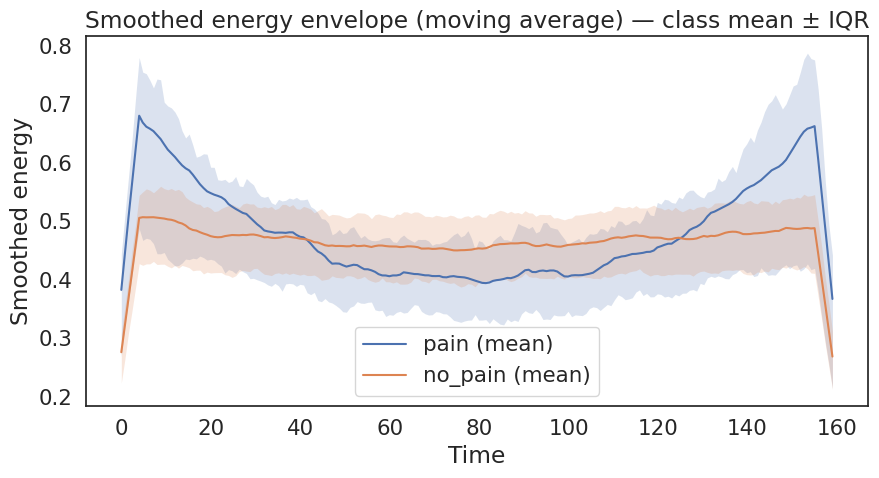

In [22]:
# ======================= SETUP =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.signal import hilbert

# ОЖИДАЕМ:
# dataset_train: колонки ['sample_index','time','joint_...'] (сырые, НЕ стандартизированные)
# dataset_labels: ['sample_index','label'] где label ∈ {'no_pain','low_pain','high_pain'}

# ------------ ПАРАМЕТРЫ ------------
RESAMPLE_POINTS = 200        # число узлов единой временной сетки
CENTER_PER_CHANNEL = True    # вычитать среднее по каналу внутри sample (НЕ avg-ref!)
EPS = 1e-12                  # для стабильности деления при маленьком RMS
SMOOTH_WIN = 11              # окно для сглаживания профиля энергии (в узлах общей сетки)

# ======================= 1) MERGE + маппинг меток =======================
df = dataset_train_with_disability.merge(dataset_labels, on='sample_index', how='left').copy()
df['is_pain'] = df['label'].map({'no_pain': False, 'low_pain': True, 'high_pain': True})
df = df[~df['is_pain'].isna()].copy()
df['is_pain'] = df['is_pain'].astype(bool)

joint_cols = sorted([c for c in df.columns if c.startswith('joint_')])

# ======================= 2) УТИЛИТЫ =======================
def per_sample_channel_rms_normalize(group: pd.DataFrame, cols, center=True, eps=1e-12):
    """Нормализация: (x - mean_channel)/RMS_channel внутри sample_index, по каждому каналу отдельно.
       Без сквозной нормализации по датасету, без avg-reference."""
    X = group[cols].to_numpy(dtype=float)              # [T,C]
    if center:
        X = X - np.nanmean(X, axis=0, keepdims=True)   # убрать DC каждого канала
    rms = np.sqrt(np.nanmean(X**2, axis=0, keepdims=True))  # [1,C]
    Xn = X / np.maximum(rms, eps)
    out = group.copy()
    out[cols] = Xn
    return out, rms.ravel()

def resample_to_grid(t, y, grid):
    """Интерполяция по времени на заданную сетку.
       y: [T] или [T,C]"""
    t = np.asarray(t, float)
    if y.ndim == 1:
        return np.interp(grid, t, y)
    else:
        Y = np.empty((grid.size, y.shape[1]), dtype=float)
        for c in range(y.shape[1]):
            Y[:, c] = np.interp(grid, t, y[:, c])
        return Y

def moving_average(v, win):
    win = max(1, int(win))
    if win == 1:
        return v
    kernel = np.ones(win)/win
    return np.convolve(v, kernel, mode='same')

# ======================= 3) НОРМАЛИЗАЦИЯ + ЭНЕРГИИ ПО СЭМПЛАМ =======================
# Контейнеры для метрик по sample_index
sample_rows = []

# Временные профили для усреднения (на общей сетке)
profiles_inst = {'pain': [], 'nopain': []}          # мгновенная энергия
profiles_cum  = {'pain': [], 'nopain': []}          # накопленная энергия
profiles_env  = {'pain': [], 'nopain': []}          # сглаженная/энвелопа энергии

# Общая сетка времени (по квантилям глобального времени)
# Берём глобальный min/max для унификации сетки
t_min = df['time'].min()
t_max = df['time'].max()
t_grid = np.linspace(t_min, t_max, RESAMPLE_POINTS)

for sid, g in df.groupby('sample_index'):
    g = g.sort_values('time')
    is_pain = bool(g['is_pain'].iloc[0])
    cls_key = 'pain' if is_pain else 'nopain'

    # per-sample per-channel RMS нормализация
    g_norm, rms_vec = per_sample_channel_rms_normalize(g, joint_cols, center=CENTER_PER_CHANNEL, eps=EPS)

    # матрица сигналов [T,C] после нормализации
    X = g_norm[joint_cols].to_numpy(float)
    t = g_norm['time'].to_numpy(float)

    # МГНОВЕННАЯ МОЩНОСТЬ по каналам: x^2, затем агрегируем по каналам (робастно — медиана)
    pow_ch = X**2                        # [T,C]
    pow_inst = np.median(pow_ch, axis=1) # [T]

    # НАКОПЛЕННАЯ ЭНЕРГИЯ: корректно интегрируем по времени (неравномерная сетка)
    # cumtrapz возвращает на N-1 точке; дополняем нулём в начале
    cum_en = np.concatenate([[0.0], cumulative_trapezoid(pow_inst, t)])

    # Полная энергия записи (интеграл по времени)
    total_en = float(cum_en[-1])

    # Ресемплируем профили на общую сетку (для последующего усреднения по классам)
    pow_inst_rs = resample_to_grid(t, pow_inst, t_grid)             # [G]
    cum_en_rs   = resample_to_grid(t, cum_en,   t_grid)             # [G]

    # «Envelope-bursts»: сглаженный профиль энергии (скользящее среднее)
    env_rs = moving_average(pow_inst_rs, SMOOTH_WIN)

    # Копим
    profiles_inst[cls_key].append(pow_inst_rs)
    profiles_cum[cls_key].append(cum_en_rs)
    profiles_env[cls_key].append(env_rs)

    sample_rows.append({
        'sample_index': sid,
        'is_pain': is_pain,
        'total_energy': total_en
    })

sample_df = pd.DataFrame(sample_rows)

# ======================= 4) ФУНКЦИИ ДЛЯ ГРАФИКОВ (усреднение по классам) =======================
def class_mean_median(profiles):
    # profiles: list of [G] массивов
    A = np.vstack(profiles) if len(profiles)>0 else np.zeros((1, t_grid.size))
    mean = A.mean(axis=0)
    med  = np.median(A, axis=0)
    q25  = np.quantile(A, 0.25, axis=0)
    q75  = np.quantile(A, 0.75, axis=0)
    return mean, med, q25, q75

# ======================= 5) РИСУЕМ ГРАФИКИ =======================
plt.figure(figsize=(9,5))
for cls_key, label in [('pain','pain'), ('nopain','no_pain')]:
    mean, med, q25, q75 = class_mean_median(profiles_cum[cls_key])
    plt.plot(t_grid, mean, label=f'{label} (mean)')
    plt.fill_between(t_grid, q25, q75, alpha=0.2, linewidth=0)
plt.title('Cumulative energy over time (per-sample RMS normalized)')
plt.xlabel('Time (units)'); plt.ylabel('Cumulative energy')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,5))
for cls_key, label in [('pain','pain'), ('nopain','no_pain')]:
    mean, med, q25, q75 = class_mean_median(profiles_inst[cls_key])
    plt.plot(t_grid, mean, label=f'{label} (mean)')
    plt.fill_between(t_grid, q25, q75, alpha=0.2, linewidth=0)
plt.title('Instantaneous energy profile (median over channels, per-sample RMS)')
plt.xlabel('Time (units)'); plt.ylabel('Power x(t)^2')
plt.yscale('log')   # часто полезно
plt.legend(); plt.tight_layout(); plt.show()

# Boxplot/Violin по суммарным энергиям
fig, ax = plt.subplots(1,2, figsize=(11,4))
pain_e   = sample_df.loc[sample_df['is_pain'], 'total_energy'].to_numpy()
nopain_e = sample_df.loc[~sample_df['is_pain'], 'total_energy'].to_numpy()

ax[0].boxplot([nopain_e, pain_e], labels=['no_pain','pain'], showfliers=False)
ax[0].set_title('Total energy per sample (boxplot)')
ax[0].set_ylabel('Energy')

parts = ax[1].violinplot([nopain_e, pain_e], showmeans=True, showextrema=True)
ax[1].set_xticks([1,2]); ax[1].set_xticklabels(['no_pain','pain'])
ax[1].set_title('Total energy per sample (violin)')
plt.tight_layout(); plt.show()

# Heatmaps: сортируем сэмплы по полной энергии, рисуем матрицы [N_samples x G]
def plot_heatmap(class_key, title):
    profs = profiles_inst[class_key]
    if len(profs)==0:
        return
    A = np.vstack(profs)  # [N,G]
    order = np.argsort(A.sum(axis=1))
    A = A[order]
    plt.figure(figsize=(9, max(3, 0.15*A.shape[0])))
    plt.imshow(A, aspect='auto', origin='lower',
               extent=[t_grid[0], t_grid[-1], 0, A.shape[0]])
    plt.colorbar(label='Power')
    plt.title(title)
    plt.xlabel('Time'); plt.ylabel('sample # (sorted)')
    plt.tight_layout(); plt.show()

plot_heatmap('nopain', 'Heatmap of instantaneous energy (no_pain)')
plot_heatmap('pain',   'Heatmap of instantaneous energy (pain)')

# Envelope-bursts: сглаженная энергия
plt.figure(figsize=(9,5))
for cls_key, label in [('pain','pain'), ('nopain','no_pain')]:
    mean, med, q25, q75 = class_mean_median(profiles_env[cls_key])
    plt.plot(t_grid, mean, label=f'{label} (mean)')
    plt.fill_between(t_grid, q25, q75, alpha=0.2, linewidth=0)
plt.title('Smoothed energy envelope (moving average) — class mean ± IQR')
plt.xlabel('Time'); plt.ylabel('Smoothed energy')
plt.legend(); plt.tight_layout(); plt.show()


In [23]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# ========== НОРМАЛИЗАЦИЯ ВНУТРИ SAMPLE ==========
def preprocess_sample(df_sample, joint_cols):
    df_sample = df_sample.sort_values("time").copy()
    X = df_sample[joint_cols].to_numpy(float)      # [T, C]

    # 1) detrend по каналу
    X = X - X.mean(axis=0, keepdims=True)

    # 2) per-sample per-channel RMS
    rms = np.sqrt(np.mean(X**2, axis=0, keepdims=True))
    rms[rms < 1e-12] = 1e-12
    X = X / rms

    return X

In [24]:
def create_windows(X, win=32, stride=16):
    T, C = X.shape
    windows = []
    for start in range(0, T - win + 1, stride):
        w = X[start:start+win]
        windows.append(w)
    return windows

In [25]:
def build_dataset(dataset_train, dataset_labels, join_on="sample_index",
                  win=32, stride=16):
    df = dataset_train.merge(dataset_labels, on=join_on, how="left").copy()
    df['is_pain'] = df['label'].map({'no_pain': 0, 'low_pain': 1, 'high_pain': 1})
    df = df[~df['is_pain'].isna()].copy()
    df['is_pain'] = df['is_pain'].astype(int)

    joint_cols = sorted([c for c in df.columns if c.startswith("joint_")])

    X_all = []
    y_all = []

    for sid, g in df.groupby("sample_index"):
        X_norm = preprocess_sample(g, joint_cols)       # [T, C]
        windows = create_windows(X_norm, win, stride)   # list of [win, C]

        for w in windows:
            X_all.append(w)
            y_all.append(int(g['is_pain'].iloc[0]))

    X_all = np.stack(X_all)          # [N, win, C]
    y_all = np.array(y_all)          # [N]

    return X_all, y_all

In [26]:
def train_model(model, loader, epochs=20, lr=1e-3, device="cuda"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    for ep in range(epochs):
        model.train()
        total = 0
        correct = 0
        loss_sum = 0

        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()

            loss_sum += loss.item()
            pred = out.argmax(1)
            correct += (pred == yb).sum().item()
            total += len(yb)

        print(f"epoch {ep+1}: loss={loss_sum/len(loader):.4f}, acc={correct/total:.3f}")


In [28]:
class PainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, win, C]
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # CNN ожидает [batch, C, T]
        x = self.X[idx].permute(1, 0)
        y = self.y[idx]
        return x, y

In [29]:
class CNN1D(nn.Module):
    def __init__(self, C, win):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(C, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.AdaptiveAvgPool1d(1)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.fc(self.net(x))


In [30]:
# Собрать датасет
X, y = build_dataset(dataset_train, dataset_labels, win=32, stride=16)

# DataLoader
train_ds = PainDataset(X, y)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# Модель
C = X.shape[2]
win = X.shape[1]
model = CNN1D(C, win)

# Обучение
train_model(model, train_loader, epochs=20, lr=1e-3, device="cuda")

AttributeError: module 'torch.nn' has no attribute 'Conv1D'